<a href="https://colab.research.google.com/github/mongbro/colab/blob/main/08_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### keras RNN으로 비트코인 시세 예측하기

1. 패키지 수입 및 파라미터 지정

In [ ]:
# 패키지 수입
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# 파라미터 지정
MY_PAST = 5
MY_HIDDEN = 256
MY_EPOCH = 100

2. 데이터 처리

In [ ]:
# 데이터 읽기
raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/BTC-USD.csv',
                  usecols = ['Date', 'Close'],
                  parse_dates = True,
                  index_col = 'Date')

# 샘플 데이터 출력
print(raw.head(10))

# 데이터 통계
print(raw.describe())


                 Close
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014
2014-09-22  402.152008
2014-09-23  435.790985
2014-09-24  423.204987
2014-09-25  411.574005
2014-09-26  404.424988
              Close
count   2309.000000
mean    5080.521166
std     5268.144533
min      178.102997
25%      446.721985
50%     3906.717285
75%     8510.379883
max    40797.609375


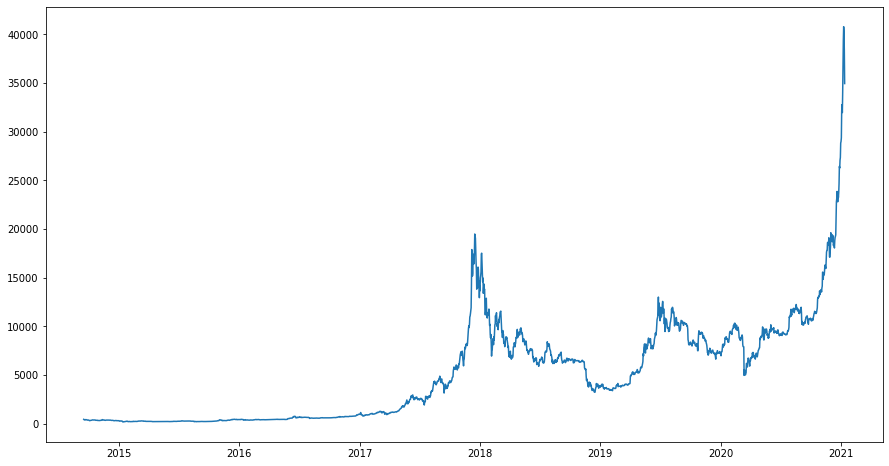

In [ ]:
# 그래프
plt.figure(figsize = (15, 8))
plt.plot(raw)

In [ ]:
# 데이터 정규화
scaler = MinMaxScaler()
#scaler = StandardScaler()
s_data = scaler.fit_transform(raw)

print('원본 데이터 형식 :', type(raw))
print('정규화 데이터 형식 :', type(s_data))

# pandas로 재전환
tmp = pd.DataFrame(s_data)
print(tmp.head(10))
print(tmp.describe())

원본 데이터 형식 : <class 'pandas.core.frame.DataFrame'>
정규화 데이터 형식 : <class 'numpy.ndarray'>
          0
0  0.006874
1  0.006065
2  0.005335
3  0.005682
4  0.005434
5  0.005516
6  0.006344
7  0.006034
8  0.005748
9  0.005572
                 0
count  2309.000000
mean      0.120691
std       0.129695
min       0.000000
25%       0.006613
50%       0.091794
75%       0.205130
max       1.000000


In [ ]:
# 데이터를 6개의 묶음으로 분할
data = []

for i in range (len(s_data) - MY_PAST):
    data.append(s_data[i : i + MY_PAST + 1])
                    # [출발점 : 도착점 - 1]
print('한 묶음의 크기 :', len(data[0]))
print('총 묶음의 수 :', len(data))
print('첫번째 묶음 내용 \n', data[0])   # 첫째날부터 5번째날 까지의 가격 + 6번째날 가격
print('두번째 묶음 내용 \n', data[1])   # 둘째날부터 6번째날 까지의 가격 + 7번째날 가격

한 묶음의 크기 : 6
총 묶음의 수 : 2304
첫번째 묶음 내용 
 [[0.00687431]
 [0.0060645 ]
 [0.0053347 ]
 [0.00568202]
 [0.00543379]
 [0.0055158 ]]
두번째 묶음 내용 
 [[0.0060645 ]
 [0.0053347 ]
 [0.00568202]
 [0.00543379]
 [0.0055158 ]
 [0.00634395]]


In [ ]:
# 데이터를 입력과 출력으로 분할
# 데이터를 numpy로 전환
print(type(data))
data = np.array(data)
print(type(data))

# 묶음들을 임의로 섞음
print(data.shape)

# 데이터를 입력과 출력으로 분할
X_data = data[:, 0 : MY_PAST]   # 입력데이터 열 : [행 자르는 곳, 열 자르는 곳]
Y_data = data[:, -1]            # 출력데이터 열 : [:,:] 행을 모두, 열을 모두 취한다.

print('입력 데이터 모양 :', X_data.shape)   # ==> (x, y, z) 3차원인 이유 :
print('출력 데이터 모양 :', Y_data.shape)   #      >> LSTM의 입력이 3차원 데이터라서

<class 'list'>
<class 'numpy.ndarray'>
(2304, 6, 1)
입력 데이터 모양 : (2304, 5, 1)
출력 데이터 모양 : (2304, 1)


In [ ]:
# 데이터 4분할 안함.
'''
X_train, X_test, Y_train, Y_test = train_test_split(X_data, 
                                                    Y_data, 
                                                    train_size = MY_SPLIT,
                                                    shuffle = False)

# 최종 데이터 모양 출력
print('학습용 입력데이터 모양 :', X_train.shape)
print('학습용 출력데이터 모양 :', Y_train.shape)
print('평가용 입력데이터 모양 :', X_test.shape)
print('평가용 출력데이터 모양 :', Y_test.shape)
'''
X_train = X_data
Y_train = Y_data

3. 인공 신경망 구현


In [ ]:
# RNN 구현
model = Sequential()

model.add(LSTM(units = MY_HIDDEN,
               input_shape=(MY_PAST, 1)))

model.add(Dense(units = 1))

print('RNN 요약')
model.summary()

RNN 요약
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


4. 인공 신경망 학습

In [ ]:
# RNN 학습
model.compile(optimizer = 'adam',
              loss = 'mse')

print('학습 시작')
begin = time()

model.fit(x = X_train,
          y = Y_train,
          epochs = MY_EPOCH,
          verbose = 0)

end = time()
print('학습시간 : {:.2f}초'.format(end - begin))

학습 시작
학습시간 : 16.85초


5. 인공 신경망 평가

In [ ]:
'''
# RNN 평가
score = model.evaluate(x = X_test,
                       y = Y_test,
                       verbose = 0)

print('최종 손실값 :{:.7f}'.format(score))
'''

"\n# RNN 평가\nscore = model.evaluate(x = X_test,\n                       y = Y_test,\n                       verbose = 0)\n\nprint('최종 손실값 :{:.7f}'.format(score))\n"

6. 인공 신경망 예측

In [ ]:
# 최근 시세 출력
print('최근 6일 비트코인 시세 >>')
print(raw.tail(MY_PAST + 1))

최근 6일 비트코인 시세 >>
                   Close
Date                    
2021-01-06  36824.363281
2021-01-07  39371.042969
2021-01-08  40797.609375
2021-01-09  40254.546875
2021-01-10  38356.441406
2021-01-11  34954.035156


In [ ]:
# RNN으로 오늘 시세 예측
last = X_train[-1]                          # ==> 정규화된 데이터
last_ori = scaler.inverse_transform(last)   # ==> 정규화 풀린 데이터
print(last_ori, '\n')   # 5일 전부터 어제까지 데이터

# 정규화된 데이터 준비
# 배치 정보 맨 앞에 추가
last = last.reshape(1, 5, 1)
pred = model.predict(last)

pred_ori = scaler.inverse_transform(pred)

print('오늘의 시세 RNN 추측 결과(정규화)', pred)
print('오늘의 시세 RNN 추측 결과(역정규화)', pred_ori)
print('오차 :', abs(pred_ori - raw['Close'][-1]))

[[36824.363281]
 [39371.042969]
 [40797.609375]
 [40254.546875]
 [38356.441406]] 

오늘의 시세 RNN 추측 결과(정규화) [[0.927455]]
오늘의 시세 RNN 추측 결과(역정규화) [[37850.867]]
오차 : [[2896.832]]


In [ ]:
# RNN으로 내일 시세 예측
tmp = raw.to_numpy()
tom = tmp[len(tmp) - MY_PAST :]  # len(tmp) == 몇일의 데이터를 가지고 있는가
                                 # len(tmp) - MY_PAST == 2309 - 5 = 2304
                                 # tom = [2304 : 2309]
                                 # 2304, 2305, 2306. 2307. 2308 ==>> 총 5개

print('최근 5일 시세')
print(tom)

최근 5일 시세
[[39371.042969]
 [40797.609375]
 [40254.546875]
 [38356.441406]
 [34954.035156]]


In [ ]:
# 데이터 정규화 및 배치정보 추가
tom = scaler.fit_transform(tom)
tom = tom.reshape(1, 5, 1)

# RNN 입력
pred = model.predict(tom)
pred_ori = scaler.inverse_transform(pred)
print('내일 비트코인 시세(정규화 된 값) :', pred)
print('내일 비트코인 시세(역정규화 된 값) :', pred_ori)

내일 비트코인 시세(정규화 된 값) : [[-0.04990686]]
내일 비트코인 시세(역정규화 된 값) : [[34662.4]]
